In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.auto import trange

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("../../../../estsoft/data/train.csv")
def fill_null(df:pd.DataFrame, time_before:list, time:list, time_after:list):
    df_fill = pd.DataFrame()
    for i in range(len(time_before)):
        df_null = df[df['datetime']==time[i]]
        df_concat = pd.concat([df[df['datetime']==time_before[i]], df[df['datetime']==time_after[i]]])

        # null값의 앞뒤 시간의 평균값 계산 및 저장
        ab_mean = pd.DataFrame(df_concat.groupby(['prediction_unit_id'])['target'].sum()/2).reset_index()
        df_merge = pd.merge(df_null, ab_mean, how='left', on='prediction_unit_id').drop(columns='target_x').rename(columns={'target_y':'target'})
        df_fill = pd.concat([df_fill, df_merge])

        # null값이 있는 행 drop
        df = df.drop(df_null.index)

    df = pd.concat([df, df_fill]).reset_index(drop=True).sort_values(by='datetime')
    return df
df_prod =df[df['is_consumption']==0]
df_cons = df[df['is_consumption']==1]

time_before = ['2022-10-30 02:00:00', '2022-03-27 02:00:00', '2023-03-26 02:00:00', '2021-10-31 02:00:00']
time = ['2022-10-30 03:00:00', '2022-03-27 03:00:00', '2023-03-26 03:00:00', '2021-10-31 03:00:00']
time_after = ['2022-10-30 04:00:00', '2022-03-27 04:00:00', '2023-03-26 04:00:00', '2021-10-31 04:00:00']

df_prod = fill_null(df_prod, time_before, time, time_after)
df_cons = fill_null(df_cons, time_before, time, time_after)

In [4]:
df_prod['datetime'] = pd.to_datetime(df_prod['datetime'])
print(df_prod.info())
df_prod.set_index('datetime', drop=True, inplace=True) 

df_cons['datetime'] = pd.to_datetime(df_cons['datetime'])
print(df_cons.info())
df_cons.set_index('datetime', drop=True, inplace=True) 

<class 'pandas.core.frame.DataFrame'>
Index: 1009176 entries, 0 to 1008853
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   county              1009176 non-null  int64         
 1   is_business         1009176 non-null  int64         
 2   product_type        1009176 non-null  int64         
 3   target              1009176 non-null  float64       
 4   is_consumption      1009176 non-null  int64         
 5   datetime            1009176 non-null  datetime64[ns]
 6   data_block_id       1009176 non-null  int64         
 7   row_id              1009176 non-null  int64         
 8   prediction_unit_id  1009176 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 77.0 MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1009176 entries, 0 to 1008853
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype         
---  ------    

In [5]:
# f"df_prod{n}"
df_prod_list = []
for id in df_prod['prediction_unit_id'].unique():
    exec(f"df_prod{id} = df_prod[df_prod['prediction_unit_id']=={id}]")
    exec(f"df_prod_list.append('df_prod{id}')")

# f"df_cons{n}"
df_cons_list = []
for id in df_cons['prediction_unit_id'].unique():
    exec(f"df_cons{id} = df_cons[df_cons['prediction_unit_id']=={id}]")
    exec(f"df_cons_list.append('df_cons{id}')")

In [7]:
data = pd.DataFrame(df_prod0.target)
data

,target
datetime,
2021-09-01 00:00:00,0.713
2021-09-01 01:00:00,1.132
2021-09-01 02:00:00,0.490
2021-09-01 03:00:00,0.496
2021-09-01 04:00:00,0.149
...,...
2023-05-31 19:00:00,439.610
2023-05-31 20:00:00,120.856
2023-05-31 21:00:00,22.428


# PatchTST

In [73]:
class PatchTSDataset(torch.utils.data.Dataset):
  def __init__(self, ts:np.array, patch_length:int=16, n_patches:int=6, prediction_length:int=4):
    self.P = patch_length
    self.N = n_patches
    self.L = int(patch_length * n_patches / 2)  # look-back window length
    self.T = prediction_length
    self.data = ts

  def __len__(self):
    return len(self.data) - self.L - self.T + 1

  def __getitem__(self, i):
    look_back = self.data[i:(i+self.L)]
    look_back = np.concatenate([look_back, look_back[-1]*np.ones(int(self.P / 2), dtype=np.float32)])
    x = np.array([look_back[i*int(self.P/2):(i+2)*int(self.P/2)] for i in range(self.N)])
    y = self.data[(i+self.L):(i+self.L+self.T)]
    return x, y

In [74]:
from sklearn.preprocessing import MinMaxScaler

patch_length = 16
n_patches = 8
prediction_length = 4
window_size = int(patch_length * n_patches / 2)
tst_size = 96

scaler = MinMaxScaler()
trn_scaled = scaler.fit_transform(data[:-tst_size].to_numpy(dtype=np.float32)).flatten()
tst_scaled = scaler.transform(data[-tst_size-window_size:].to_numpy(dtype=np.float32)).flatten()

trn_ds = PatchTSDataset(trn_scaled, patch_length, n_patches)
tst_ds = PatchTSDataset(tst_scaled, patch_length, n_patches)

trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=32, shuffle=True)
tst_dl = torch.utils.data.DataLoader(tst_ds, batch_size=tst_size, shuffle=False)

In [75]:
x, y = next(iter(trn_dl))
x.shape, y.shape

(torch.Size([32, 8, 16]), torch.Size([32, 4]))

In [76]:
m_data = data.copy()
m_data['rolling_mean'] = data.target.rolling(11).mean()
m_data

,target,rolling_mean
datetime,,
2021-09-01 00:00:00,0.713,NaN
2021-09-01 01:00:00,1.132,NaN
2021-09-01 02:00:00,0.490,NaN
2021-09-01 03:00:00,0.496,NaN
2021-09-01 04:00:00,0.149,NaN
...,...,...
2023-05-31 19:00:00,439.610,2067.587091
2023-05-31 20:00:00,120.856,1919.228727
2023-05-31 21:00:00,22.428,1702.432727


In [77]:
m_data = m_data.dropna()

In [78]:
scaler2 = MinMaxScaler()

trn2_scaled = scaler2.fit_transform(m_data['rolling_mean'][:-tst_size].to_numpy(dtype=np.float32).reshape(-1,1)).flatten()

trn2_ds = PatchTSDataset(trn2_scaled, patch_length, n_patches)

trn_ds = torch.utils.data.ConcatDataset([trn_ds, trn2_ds])

trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=32, shuffle=True)

In [79]:
x, y = next(iter(trn_dl))
x.shape, y.shape

(torch.Size([32, 8, 16]), torch.Size([32, 4]))

In [80]:
class PatchTST(nn.Module):
  def __init__(self, n_token, input_dim, model_dim, num_heads, num_layers, output_dim):
    super(PatchTST, self).__init__()
    self.patch_embedding = nn.Linear(input_dim, model_dim)    # Input Embedding
    self._pos = torch.nn.Parameter(torch.randn(1,1,model_dim))  # Positional Embedding

    encoder_layers = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, batch_first=True)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

    self.output_layer = nn.Linear(model_dim * n_token, output_dim)

  def forward(self, x):
    # x shape: (batch_size, n_token, token_size)
    x = self.patch_embedding(x)   # (batch_size, n_token, model_dim)
    x = x + self._pos
    x = self.transformer_encoder(x)   # (batch_size, n_token, model_dim)
    x = x.view(x.size(0), -1)       # (batch_size, n_token * model_dim)
    output = self.output_layer(x)   # (batch_size, out_dim =4 patch_size == 4)
    return F.sigmoid(output)

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [87]:
model = PatchTST(n_patches, patch_length, 128, 8, 4, prediction_length)
model.to(device)

optim = torch.optim.AdamW(model.parameters(), lr=0.0001)

pbar = trange(10)
for _ in pbar:
  model.train()
  trn_loss = 0.
  for x,y in trn_dl:
    x, y = x.to(device), y.to(device)
    p = model(x)
    optim.zero_grad()
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()*len(x)
  trn_loss = trn_loss / len(trn_ds)

  model.eval()
  with torch.inference_mode():
    x, y = next(iter(tst_dl))
    x, y = x.to(device), y.to(device)
    p = model(x)
    tst_loss = F.mse_loss(p,y)
  pbar.set_postfix({'loss':trn_loss, 'tst_loss':tst_loss.item()})

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:50<00:00, 11.04s/it, loss=0.00142, tst_loss=0.00736]


In [84]:
def mape(y_pred, y_true):
  return (np.abs(y_pred - y_true)/y_true).mean() * 100

def mae(y_pred, y_true):
  return np.abs(y_pred - y_true).mean()

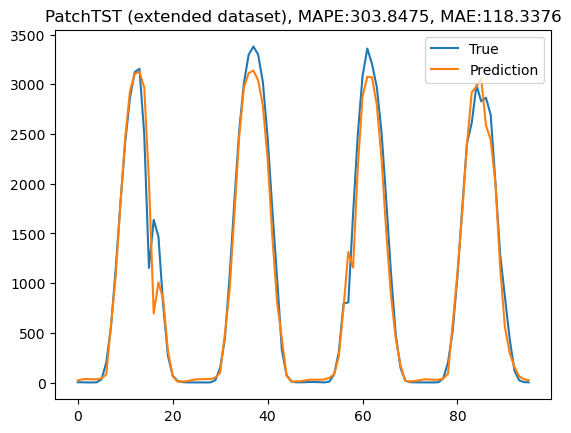

In [89]:
# model = PatchTST(n_patches, patch_length, 128, 8, 4, prediction_length), epoch 10
res_dict = {}

model.eval()
with torch.inference_mode():
  x, y = next(iter(tst_dl))
  x, y = x.to(device), y.to(device)
  p = model(x)

y = scaler.inverse_transform(y.cpu())
p = scaler.inverse_transform(p.cpu())

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])

plt.title(f"PatchTST (extended dataset), MAPE:{mape(torch.Tensor(p),torch.Tensor(y)):.4f}, MAE:{mae(torch.Tensor(p),torch.Tensor(y)):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

res_dict.update({'PatchTST/8': {'MAPE':mape(p,y), 'MAE':mae(p,y)}})

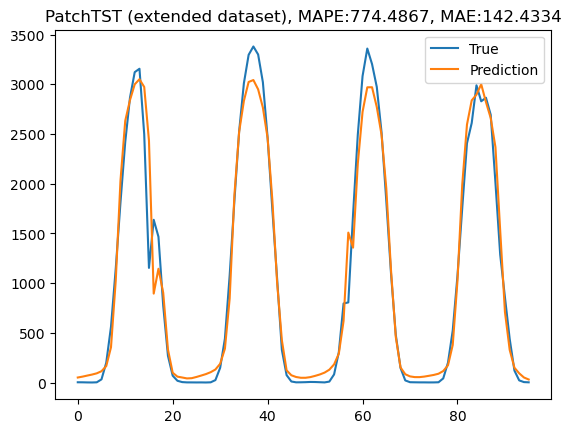

In [85]:
# model = PatchTST(n_patches, patch_length, 256, 8, 4, prediction_length), epoch 1
res_dict = {}

model.eval()
with torch.inference_mode():
  x, y = next(iter(tst_dl))
  x, y = x.to(device), y.to(device)
  p = model(x)

y = scaler.inverse_transform(y.cpu())
p = scaler.inverse_transform(p.cpu())

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])

plt.title(f"PatchTST (extended dataset), MAPE:{mape(torch.Tensor(p),torch.Tensor(y)):.4f}, MAE:{mae(torch.Tensor(p),torch.Tensor(y)):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

res_dict.update({'PatchTST/8': {'MAPE':mape(p,y), 'MAE':mae(p,y)}})

In [86]:
pd.DataFrame(res_dict)

,PatchTST/8
MAE,142.433408
MAPE,774.486639
